<a href="https://colab.research.google.com/github/MasaAsami/commentary_mjca/blob/main/notebooks/mjca_simdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn のスタイルとコンテキストを設定
sns.set_style("ticks")          # クリーンなスタイル
sns.set_context("paper")        # 論文用のコンテキスト設定


# 以下が本名

In [40]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import PolynomialFeatures

def generate_random_correlation_matrix(dim, seed=None):
    """
    指定された次元数に基づいてランダムな相関行列を生成する。
    """
    if seed is not None:
        np.random.seed(seed)

    # ランダムな正定値行列を生成
    A = np.random.rand(dim, dim)
    sym_A = (A + A.T) / 2  # 対称行列にする
    eigvals, eigvecs = np.linalg.eigh(sym_A)  # 固有値と固有ベクトルを計算

    # 正の固有値を持つように調整
    positive_eigvals = np.abs(eigvals) + 1e-3  # 小さい値を足してゼロ回避
    positive_definite_matrix = eigvecs @ np.diag(positive_eigvals) @ eigvecs.T

    # 標準化して相関行列に変換
    std_devs = np.sqrt(np.diag(positive_definite_matrix))
    correlation_matrix = positive_definite_matrix / np.outer(std_devs, std_devs)

    return correlation_matrix

class LinearDataGenerator:
    def __init__(self, N=1000, X_dim=10, noise_std=2, seed=42):
        self.N = N
        self.X_dim = X_dim
        self.seed = seed
        self.noise_std = noise_std
        np.random.seed(self.seed)

    def generate_data(self):
        N = self.N
        X_dim =  self.X_dim
        # 特徴量Xの生成
        correlation_matrix = generate_random_correlation_matrix(dim=X_dim, seed=self.seed)
        x_mean = np.zeros(X_dim)
        X = np.random.multivariate_normal(mean=x_mean, cov=correlation_matrix, size=N)
        X = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X_dim)])

        feature_cols = X.columns.tolist()

        # 処遇Aの割り当て（線形モデル）
        beta = np.random.uniform(-1, 0.5, len(feature_cols))
        logits = X.values @ beta + np.random.normal(0, 0.5, N)
        prob_A = 1 / (1 + np.exp(-logits))
        A = np.random.binomial(1, prob_A)


        # 反実仮想のアウトカムRを生成
        _beta_A0 = np.random.uniform(0, 2, len(feature_cols))
        gamma_A0 = np.abs(_beta_A0) * beta
        _beta_A1 = np.random.uniform(0, 1.5, len(feature_cols))
        gamma_A1 = np.abs(_beta_A1) * beta* -1

        noise = np.random.normal(0, self.noise_std, N)

        # 処遇なしの場合のアウトカム R(A=0)
        logits_R_A0 = X.values @ gamma_A0  +  noise
        prob_R_A0 = 1 / (1 + np.exp(-logits_R_A0))
        R_A0 = np.random.binomial(1, prob_R_A0)

        # 処遇ありの場合のアウトカム R(A=1)
        logits_R_A1 = X.values @ gamma_A1  +  noise
        prob_R_A1 = 1 / (1 + np.exp(-logits_R_A1))
        R_A1 = np.random.binomial(1, prob_R_A1)

        # 観測されたアウトカム R は、実際の処遇 A に対応するもの
        R = np.where(A == 1, R_A1, R_A0)

        # データフレームの作成
        data = X.copy()
        data['A'] = A
        data['R'] = R
        data["true_prob_A"] = prob_A
        data['R_A0'] = R_A0  # 反実仮想のアウトカム
        data['R_A1'] = R_A1  # 反実仮想のアウトカム

        return data, feature_cols[:X_dim]

class DataGenerator:
    def __init__(self, N=1000, X_dim=10, degree=2, original_dim_times=2,interaction_only=True, noise_std=2, seed=42):
        self.N = N
        self.X_dim = X_dim
        self.degree = degree
        self.original_dim_times = original_dim_times
        self.interaction_only = interaction_only
        self.seed = seed
        self.noise_std = noise_std
        np.random.seed(self.seed)

    def generate_data(self):
        N = self.N
        X_dim_original = self.X_dim
        X_dim = int(X_dim_original * self.original_dim_times)
        # 特徴量Xの生成
        correlation_matrix = generate_random_correlation_matrix(dim=X_dim, seed=self.seed)
        x_mean = np.zeros(X_dim)
        X = np.random.multivariate_normal(mean=x_mean, cov=correlation_matrix, size=N)
        #X = np.random.normal(0, 1, (N, X_dim))
        X = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X_dim)])

        original_feature_cols = X.columns.tolist()

        # 処遇Aの割り当て（線形モデル）
        beta = np.random.uniform(-1, 0.5, len(original_feature_cols))
        logits = X.values @ beta + np.sin(X.sum(axis=1)) + np.random.normal(0, 0.5, N)
        prob_A = 1 / (1 + np.exp(-logits))
        A = np.random.binomial(1, prob_A)

        # 多項式特徴量の生成
        poly = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=False)
        X_poly = poly.fit_transform(X)
        feature_names = poly.get_feature_names_out(X.columns)
        X_poly = pd.DataFrame(X_poly, columns=feature_names)



        # 特徴量リストの更新
        feature_cols = X_poly.columns.tolist()

        # 反実仮想のアウトカムRを生成
        gamma = np.random.uniform(-0.5, 0.5, len(feature_cols))
        hetero_n = 5
        delta_noise = np.random.normal(0, 1, N)
        # delta = -0.5 + X_poly[feature_cols[-hetero_n:]] @ np.random.uniform(-1, 1, hetero_n) + delta_noise

        # noise = np.random.normal(0, self.noise_std, N)
        # # 処遇なしの場合のアウトカム R(A=0)
        # logits_R_A0 = X_poly.values @ gamma + noise
        # prob_R_A0 = 1 / (1 + np.exp(-logits_R_A0))
        # R_A0 = np.random.binomial(1, prob_R_A0)

        # # 処遇ありの場合のアウトカム R(A=1)
        # prob_R_A1 = prob_R_A0 * 1 / (1 + np.exp(- delta))
        # R_A1 = np.random.binomial(1, prob_R_A1)

        # delta = -1 + X_poly[feature_cols[-hetero_n:]] @ np.random.uniform(-1, 1, hetero_n) + delta_noise
        #delta = (prob_A - 0.5)*-2 + delta_noise  # 追加
        delta = -1 + (prob_A -0.2)*-2 + delta_noise

        noise = np.random.normal(0, self.noise_std, N)

        # 処遇なしの場合のアウトカム R(A=0)
        logits_R_A0 = X_poly.values @ gamma + np.cos(X.sum(axis=1)) +  noise
        prob_R_A0 = 1 / (1 + np.exp(-logits_R_A0))
        R_A0 = np.random.binomial(1, prob_R_A0)

        # 処遇ありの場合のアウトカム R(A=1)
        logits_R_A1 = logits_R_A0 + delta * np.random.normal(0, self.noise_std, N) *X_dim*0.5
        prob_R_A1 = 1 / (1 + np.exp(-logits_R_A1))
        R_A1 = np.random.binomial(1, prob_R_A1)

        # 観測されたアウトカム R は、実際の処遇 A に対応するもの
        R = np.where(A == 1, R_A1, R_A0)

        # データフレームの作成
        data = X_poly.copy()
        data['A'] = A
        data['R'] = R
        data["true_prob_A"] = prob_A
        data['R_A0'] = R_A0  # 反実仮想のアウトカム
        data['R_A1'] = R_A1  # 反実仮想のアウトカム

        return data, feature_cols[:X_dim_original]

# DR Policy Optimizer Class
class DRPolicyOptimizer:
    def __init__(self, feature_cols, feature_cols_ps):
        self.feature_cols = feature_cols
        self.feature_cols_ps = feature_cols_ps

    def estimate_ps_model(self, train_data):
        # Estimate propensity score model P(A|X)
        train_features_ps = train_data[self.feature_cols_ps]
        train_target_ps = train_data['A']

        lgb_train_ps = lgb.Dataset(train_features_ps, train_target_ps)
        params_ps = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'seed': 42
        }
        self.model_ps = lgb.train(params_ps, lgb_train_ps, num_boost_round=100)

    # def estimate_outcome_model(self, train_data):
    #     # Estimate outcome model E[R|X,A]
    #     train_features_q = train_data[self.feature_cols + ['A']]
    #     train_target_q = train_data['R']

    #     lgb_train_q = lgb.Dataset(train_features_q, train_target_q)
    #     params_q = {
    #         'objective': 'binary',
    #         'metric': 'binary_logloss',
    #         'verbosity': -1,
    #         'seed': 42
    #     }
    #     self.model_q = lgb.train(params_q, lgb_train_q, num_boost_round=100)

    #     # Also estimate outcome model E[R|X] for Case 1
    #     train_features_q_x = train_data[self.feature_cols]
    #     lgb_train_q_x = lgb.Dataset(train_features_q_x, train_target_q)
    #     self.model_q_x = lgb.train(params_q, lgb_train_q_x, num_boost_round=100)

    def estimate_outcome_model(self, train_data, linear_model=False):
        # Features and target for E[R|X,A]
        train_features_q = train_data[self.feature_cols + ['A']]
        train_target_q = train_data['R']

        if linear_model:
            # Use Logistic Regression for E[R|X,A]
            self.model_q = LogisticRegression(random_state=42, max_iter=1000)
            self.model_q.fit(train_features_q, train_target_q)
        else:
            # Use LightGBM for E[R|X,A]
            lgb_train_q = lgb.Dataset(train_features_q, train_target_q)
            params_q = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'verbosity': -1,
                'seed': 42
            }
            self.model_q = lgb.train(params_q, lgb_train_q, num_boost_round=100)

    def optimize_policy(self, train_data, num_epochs=100, batch_size=256, plot_show=True):
        # Define policy network
        class PolicyNetwork(nn.Module):
            def __init__(self, input_dim):
                super(PolicyNetwork, self).__init__()
                self.fc = nn.Sequential(
                    nn.Linear(input_dim, 16),
                    nn.ReLU(),
                    nn.Linear(16, 2),
                    nn.Softmax(dim=1)
                )

            def forward(self, x):
                return self.fc(x)

        self.policy_net = PolicyNetwork(input_dim=len(self.feature_cols))
        optimizer = optim.Adam(self.policy_net.parameters(), lr=0.01)

        # Prepare data tensors
        X_tensor = torch.tensor(train_data[self.feature_cols].values, dtype=torch.float)
        A_tensor = torch.tensor(train_data['A'].values, dtype=torch.long)
        R_tensor = torch.tensor(train_data['R'].values, dtype=torch.float)
        ps_tensor = torch.tensor(train_data['ps_hat'].values, dtype=torch.float)
        q_hat_A_tensor = torch.tensor(
            train_data['q_hat_A1'].values * train_data['A'].values +
            train_data['q_hat_A0'].values * (1 - train_data['A'].values), dtype=torch.float)

        # Clamp propensity scores for numerical stability
        ps_tensor = torch.clamp(ps_tensor, 0.05, 0.95)

        num_batches = int(np.ceil(len(train_data) / batch_size))

        for epoch in range(num_epochs):
            perm = np.random.permutation(len(train_data))
            X_tensor = X_tensor[perm]
            A_tensor = A_tensor[perm]
            R_tensor = R_tensor[perm]
            ps_tensor = ps_tensor[perm]
            q_hat_A_tensor = q_hat_A_tensor[perm]

            for i in range(num_batches):
                start = i * batch_size
                end = min((i + 1) * batch_size, len(train_data))

                X_batch = X_tensor[start:end]
                A_batch = A_tensor[start:end]
                R_batch = R_tensor[start:end]
                ps_batch = ps_tensor[start:end]
                q_hat_batch = q_hat_A_tensor[start:end]

                optimizer.zero_grad()

                # Policy network output
                pi_probs = self.policy_net(X_batch)

                # Probability of selected action
                pi_a = pi_probs.gather(1, A_batch.view(-1,1)).squeeze()

                # Compute Q-values
                indices = perm[start:end]
                q_hat_A1 = torch.tensor(train_data['q_hat_A1'].values[indices], dtype=torch.float)
                q_hat_A0 = torch.tensor(train_data['q_hat_A0'].values[indices], dtype=torch.float)

                # Compute value function V(pi)
                V_pi = ((pi_a / ps_batch) * (R_batch - q_hat_batch) +
                        pi_probs[:,1] * q_hat_A1 + pi_probs[:,0] * q_hat_A0).mean()

                # Backpropagation
                V_pi.backward()
                optimizer.step()

            # Optional: print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                if plot_show:
                    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {V_pi.item():.4f}")

        self.optimizer = optimizer  # Save optimizer if needed

    def apply_policy(self, data):
        # Apply learned policy to data
        X_tensor = torch.tensor(data[self.feature_cols].values, dtype=torch.float)
        with torch.no_grad():
            pi_probs = self.policy_net(X_tensor)
            pi_probs = pi_probs.numpy()

        data['A_policy'] = np.argmax(pi_probs, axis=1)
        return data

# DR Policy Optimizer Class
class MJCA:
    def __init__(self, feature_col):
        self.feature_cols = feature_cols

    def estimate_outcome_model(self, train_data):
        # Estimate outcome model E[R|X]
        train_features_q = train_data[self.feature_cols]
        train_target_q = train_data['R']

        lgb_train_q = lgb.Dataset(train_features_q, train_target_q)
        params_q = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'seed': 42
        }
        self.model_q = lgb.train(params_q, lgb_train_q, num_boost_round=100)

        # Also estimate outcome model E[R|X] for Case 1
        train_features_q_x = train_data[self.feature_cols]
        lgb_train_q_x = lgb.Dataset(train_features_q_x, train_target_q)
        self.model_q_x = lgb.train(params_q, lgb_train_q_x, num_boost_round=100)





In [ ]:
# シミュレーションとプロット
# サンプルサイズ
sample_sizes = [100, 1000, 2000, 5000, 10000]
X_dim = 200
# 結果を格納する辞書
sample_results = {N: {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []} for N in sample_sizes}

num_simulations = 100 # 各サンプルサイズでのシミュレーション回数

for N in sample_sizes:
    print(f"\nSample Size N={N}")
    for sim in range(num_simulations):
        # データの生成
        #data_generator = DataGenerator(N=N, X_dim=X_dim, degree=2, original_dim_times=1, interaction_only=False, noise_std=1, seed=0 + sim)
        data_generator = LinearDataGenerator(N=N, X_dim=X_dim, noise_std=5, seed=0 + sim)
        data, feature_cols_ps = data_generator.generate_data()
        # random.seed(sim)
        # feature_cols = random.sample(feature_cols_ps, 2)
        feature_cols = feature_cols_ps

        # データの分割
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

        # DRPolicyOptimizerの初期化
        dr_optimizer = DRPolicyOptimizer(feature_cols, feature_cols_ps)
        mjca = MJCA(feature_cols)

        # モデルの推定
        dr_optimizer.estimate_ps_model(train_data)
        dr_optimizer.estimate_outcome_model(train_data)
        mjca.estimate_outcome_model(train_data)

        # 学習データでの傾向スコアとQ値の予測
        train_data['ps_hat'] = dr_optimizer.model_ps.predict(train_data[feature_cols_ps])
        train_data['q_hat_A1'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=1))
        train_data['q_hat_A0'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=0))

        # ポリシーの最適化
        dr_optimizer.optimize_policy(train_data, num_epochs=100, batch_size=256, plot_show=False)

        # テストデータでの予測
        test_data['ps_hat'] = dr_optimizer.model_ps.predict(test_data[feature_cols_ps])
        test_data['q_hat_A1'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=1))
        test_data['q_hat_A0'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=0))

        test_data = dr_optimizer.apply_policy(test_data)

        # ケース0：理想的な再犯率
        test_data['A_ideal'] = (test_data['R_A1'] < test_data['R_A0']).astype(int)
        test_data['R_case0'] = np.where(test_data['A_ideal'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case0 = test_data['R_case0'].mean()
        sample_results[N]['Case0'].append(realized_R_case0)

        # ケース1：E[R|X]
        test_data['R_hat_case1'] = mjca.model_q_x.predict(test_data[feature_cols])
        test_data['A_case1'] = (test_data['R_hat_case1'] >= 0.5).astype(int)
        test_data['R_case1'] = np.where(test_data['A_case1'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case1 = test_data['R_case1'].mean()
        sample_results[N]['Case1'].append(realized_R_case1)

        # ケース2：E[R|X,A]
        test_data['A_case2'] = (test_data['q_hat_A1'] < test_data['q_hat_A0']).astype(int)
        test_data['R_case2'] = np.where(test_data['A_case2'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case2 = test_data['R_case2'].mean()
        sample_results[N]['Case2'].append(realized_R_case2)

        # ケース3：OPL (DR 推定)
        test_data['R_case3'] = np.where(test_data['A_policy'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case3 = test_data['R_case3'].mean()
        sample_results[N]['Case3'].append(realized_R_case3)

        # ケース４真のｐｓを利用
        train_data["ps_hat"] = train_data["true_prob_A"] # 上書き
        dr_optimizer.optimize_policy(train_data, num_epochs=100, batch_size=256, plot_show=False)
        test_data["ps_hat"] = test_data["true_prob_A"]  # 上書き
        test_data = dr_optimizer.apply_policy(test_data)
        test_data['R_case4'] = np.where(test_data['A_policy'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case4 = test_data['R_case4'].mean()
        sample_results[N]['Case4'].append(realized_R_case4)

        # 進行状況の表示
        if (sim + 1) % 100 == 0:
            print(f"Simulation {sim + 1}/{num_simulations} completed.")

# 各ケースの中央値と信頼区間の計算
median_results = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []}
lower_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []}
upper_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []}

for case in ['Case0', 'Case1', 'Case2', 'Case3', 'Case4']:
    for N in sample_sizes:
        data = np.array(sample_results[N][case])
        median = np.median(data)
        lower = np.percentile(data, 2.5)
        upper = np.percentile(data, 97.5)

        median_results[case].append(median)
        lower_bounds[case].append(lower)
        upper_bounds[case].append(upper)

# プロットの作成
plt.figure(figsize=(10, 6))

for case, label, color in zip(['Case1', 'Case2', 'Case3', 'Case4'],
                              ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)', 'Case 4: OPL (DR Estimation) with true ps'],
                              ['blue', 'green', 'red', "black"]):
    medians = median_results[case]
    lowers = lower_bounds[case]
    uppers = upper_bounds[case]
    plt.errorbar(sample_sizes, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt='-o', label=label, color=color, capsize=5)

# 理想的な再犯率をプロット
ideal_medians = median_results['Case0']
plt.plot(sample_sizes, ideal_medians, 'k--', label='Case 0: Ideal')

plt.xlabel('Sample Size N', fontsize=14)
plt.ylabel('Estimated Recidivism Rate', fontsize=14)
plt.title('Recidivism Rate vs Sample Size', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 理想的な再犯率との差分を計算
diff_median_results = {'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []}
diff_lower_bounds = {'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []}
diff_upper_bounds = {'Case1': [], 'Case2': [], 'Case3': [], 'Case4': []}

for _case in ['Case1', 'Case2', 'Case3', 'Case4']:
    for i, N in enumerate(sample_sizes):
        diff_data = np.array(sample_results[N][_case]) - np.array(sample_results[N]['Case0'])
        median = np.median(diff_data)
        lower = np.percentile(diff_data, 2.5)
        upper = np.percentile(diff_data, 97.5)

        diff_median_results[_case].append(median)
        diff_lower_bounds[_case].append(lower)
        diff_upper_bounds[_case].append(upper)

# 差分のプロット
plt.figure(figsize=(10, 6))

for _case, label, color in zip(['Case1', 'Case2', 'Case3','Case4'],
                              ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)', 'Case 4: OPL (DR Estimation) with true ps'],
                              ['blue', 'green', 'red', 'black']):
    medians = diff_median_results[_case]
    lowers = diff_lower_bounds[_case]
    uppers = diff_upper_bounds[_case]
    plt.errorbar(sample_sizes, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt='-o', label=label, color=color, capsize=5)

plt.xlabel('Sample Size N', fontsize=14)
plt.ylabel('Difference from Ideal Recidivism Rate', fontsize=14)
plt.title('Difference from Ideal Recidivism Rate vs Sample Size', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Sample Size N=100
Simulation 100/100 completed.

Sample Size N=1000
Simulation 100/100 completed.

Sample Size N=2000
Simulation 100/100 completed.

Sample Size N=5000


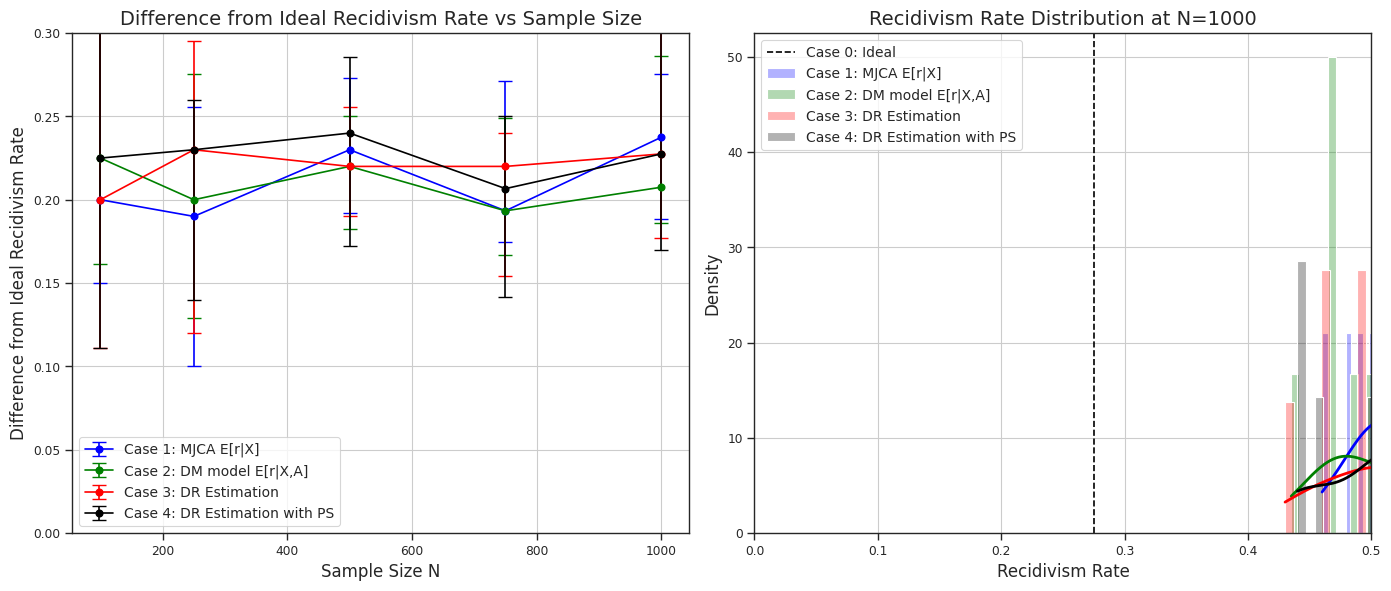

In [20]:

# 既存の結果が 'results' 辞書に格納されているとします。
# 'results' はサンプルサイズをキーとし、各ケースの結果をリストとして持つ辞書です。

# 'results' 辞書に含まれるサンプルサイズを取得
sample_sizes = sorted(sample_results.keys())

# ケース名と対応するラベル、色の設定
cases = ['Case1', 'Case2', 'Case3', 'Case4']
labels = ['Case 1 : MJCA', 'Case 2 : DM Estimation', 'Case 3 : DR Estimation', 'Case 4 : DR Estimation with PS knowlage']
colors = ['blue', 'green', 'red', 'red']

# ケース名
case_names = ['Case0', 'Case1', 'Case2', 'Case3', 'Case4']

# 統計量の計算
# median_results, lower_bounds, upper_bounds = calculate_statistics(sample_results, sample_sizes, case_names)

# 理想的な再犯率との差分を計算
diff_median_results = {_case: [] for _case in cases}
diff_lower_bounds = {_case: [] for _case in cases}
diff_upper_bounds = {_case: [] for _case in cases}

for _case in cases:
    for i, N in enumerate(sample_sizes):
        diff_data = np.array(sample_results[N][_case]) - np.array(sample_results[N]['Case0'])
        median = np.median(diff_data)
        lower = np.percentile(diff_data, 2.5)
        upper = np.percentile(diff_data, 97.5)

        diff_median_results[_case].append(median)
        diff_lower_bounds[_case].append(lower)
        diff_upper_bounds[_case].append(upper)

# プロットの作成
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左図：理想的な再犯率との差分 vs サンプルサイズ
ax = axes[0]
for _case, label, color in zip(cases, labels, colors):
    medians = diff_median_results[_case]
    lowers = diff_lower_bounds[_case]
    uppers = diff_upper_bounds[_case]

    # x と y の長さが一致していることを確認
    assert len(sample_sizes) == len(medians), f"Mismatch in lengths for {_case}: sample_sizes={len(sample_sizes)}, medians={len(medians)}"
    if _case == 'Case4':
        _fmt = "*c"
    else:
        _fmt = "-o"
    ax.errorbar(
        sample_sizes,
        medians,
        yerr=
         [
             np.array(medians) - np.array(lowers),
             np.array(uppers) - np.array(medians)
         ],
        fmt=_fmt,
        label=label,
        color=color,
        capsize=5
        )

ax.set_xlabel('Sample Size N', fontsize=12)
ax.set_ylabel('Difference from Ideal Recidivism Rate', fontsize=12)
ax.set_title('Difference from Ideal Recidivism Rate vs Sample Size', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True)
ax.set_ylim(0, 0.3)

# 右図：Cases 1〜3 の再犯率のヒストグラムと密度分布
ax = axes[1]

# N = 10000 のデータを使用（results に存在する N を使用してください）
N = 10000

data_N = pd.DataFrame(sample_results[N])

# ヒストグラムと密度分布のプロット
for _case, label, color in zip(cases, labels, colors):
    if _case == 'Case0':
        continue
    if _case == 'Case4':
        continue
    sns.histplot(data_N[_case], bins=20, color=color, label=label,
                 kde=True, stat='density', alpha=0.3, ax=ax, line_kws={'linewidth': 2})

# 理想的な再犯率の中央値に垂直の破線を引く
ideal_rate = np.median(sample_results[N]['Case0'])
ax.axvline(x=ideal_rate, color='black', linestyle='--', label='Case 0: Ideal')

ax.set_xlabel('Recidivism Rate', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Recidivism Rate Distribution at N={N}', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True)
ax.set_xlim(0, 0.5)

# 全体のレイアウト調整
plt.tight_layout()

# プロットの保存（必要に応じて）
plt.savefig('recidivism_plots.png', dpi=300)

# プロットの表示
plt.show()


Noise Std: 1.0

Noise Std: 3.25

Noise Std: 5.5

Noise Std: 7.75

Noise Std: 10.0


<ipython-input-394-75a94b2848b7>:107: RuntimeWarning: overflow encountered in exp
  prob_R_A1 = 1 / (1 + np.exp(-logits_R_A1))


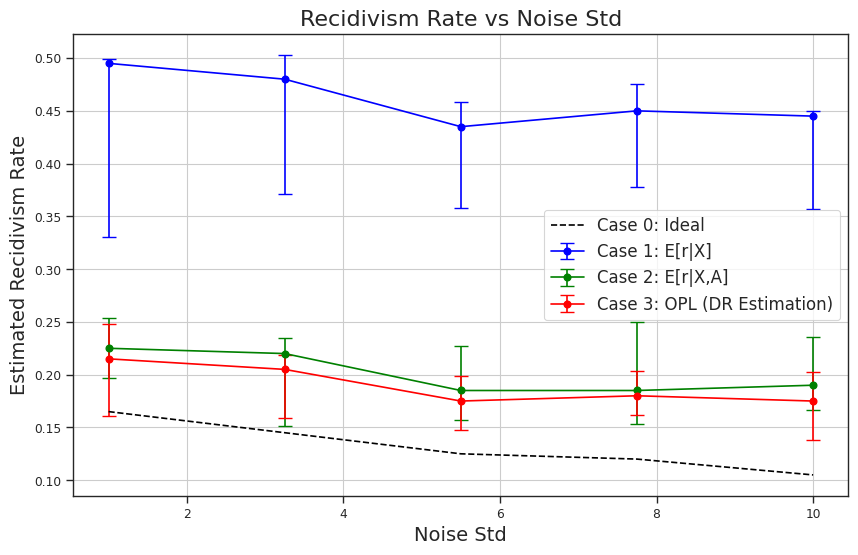

In [407]:
# ノイズ標準偏差を変化させる
noise_levels = [1, 2.5, 5, 7.5, 10] #np.linspace(1, 4, 8)
noise_levels = np.linspace(1, 10, 5)
X_dim = 10
N = 1000  # 固定のサンプルサイズ
num_simulations = 5  # 各ノイズレベルでのシミュレーション回数

# 結果を格納する辞書
results = {noise: {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []} for noise in noise_levels}

for noise_std in noise_levels:
    print(f"\nNoise Std: {noise_std}")
    for sim in range(num_simulations):
        # データの生成
        data_generator = DataGenerator(N=N, X_dim=X_dim, degree=2, interaction_only=False, noise_std=noise_std, seed=0 + sim)
        data, feature_cols_ps = data_generator.generate_data()
        feature_cols = feature_cols_ps

        # データの分割
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

        # DRPolicyOptimizerの初期化
        dr_optimizer = DRPolicyOptimizer(feature_cols, feature_cols_ps)
        mjca = MJCA(feature_cols)

        # モデルの推定
        dr_optimizer.estimate_ps_model(train_data)
        dr_optimizer.estimate_outcome_model(train_data)
        mjca.estimate_outcome_model(train_data)

        # 学習データでの傾向スコアとQ値の予測
        train_data['ps_hat'] = dr_optimizer.model_ps.predict(train_data[feature_cols_ps])
        train_data['q_hat_A1'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=1))
        train_data['q_hat_A0'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=0))

        # ポリシーの最適化
        dr_optimizer.optimize_policy(train_data, num_epochs=100, batch_size=256, plot_show=False)

        # テストデータでの予測
        test_data['ps_hat'] = dr_optimizer.model_ps.predict(test_data[feature_cols_ps])
        test_data['q_hat_A1'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=1))
        test_data['q_hat_A0'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=0))
        test_data = dr_optimizer.apply_policy(test_data)

        # ケース0：理想的な再犯率
        test_data['A_ideal'] = (test_data['R_A1'] < test_data['R_A0']).astype(int)
        test_data['R_case0'] = np.where(test_data['A_ideal'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case0 = test_data['R_case0'].mean()
        results[noise_std]['Case0'].append(realized_R_case0)

        # ケース1：E[R|X]
        test_data['R_hat_case1'] = mjca.model_q_x.predict(test_data[feature_cols])
        test_data['A_case1'] = (test_data['R_hat_case1'] >= 0.5).astype(int)
        test_data['R_case1'] = np.where(test_data['A_case1'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case1 = test_data['R_case1'].mean()
        results[noise_std]['Case1'].append(realized_R_case1)

        # ケース2：E[R|X,A]
        test_data['A_case2'] = (test_data['q_hat_A1'] < test_data['q_hat_A0']).astype(int)
        test_data['R_case2'] = np.where(test_data['A_case2'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case2 = test_data['R_case2'].mean()
        results[noise_std]['Case2'].append(realized_R_case2)

        # ケース3：OPL (DR 推定)
        test_data['R_case3'] = np.where(test_data['A_policy'] == 1, test_data['R_A1'], test_data['R_A0'])
        realized_R_case3 = test_data['R_case3'].mean()
        results[noise_std]['Case3'].append(realized_R_case3)

# 各ケースの中央値と信頼区間の計算
median_results = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
lower_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
upper_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}

for case in ['Case0', 'Case1', 'Case2', 'Case3']:
    for noise_std in noise_levels:
        data = np.array(results[noise_std][case])
        median = np.median(data)
        lower = np.percentile(data, 2.5)
        upper = np.percentile(data, 97.5)

        median_results[case].append(median)
        lower_bounds[case].append(lower)
        upper_bounds[case].append(upper)

# プロットの作成
plt.figure(figsize=(10, 6))

for case, label, color in zip(['Case1', 'Case2', 'Case3'],
                              ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)'],
                              ['blue', 'green', 'red']):
    medians = median_results[case]
    lowers = lower_bounds[case]
    uppers = upper_bounds[case]
    plt.errorbar(noise_levels, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt='-o', label=label, color=color, capsize=5)

# 理想的な再犯率をプロット
ideal_medians = median_results['Case0']
plt.plot(noise_levels, ideal_medians, 'k--', label='Case 0: Ideal')

plt.xlabel('Noise Std', fontsize=14)
plt.ylabel('Estimated Recidivism Rate', fontsize=14)
plt.title('Recidivism Rate vs Noise Std', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


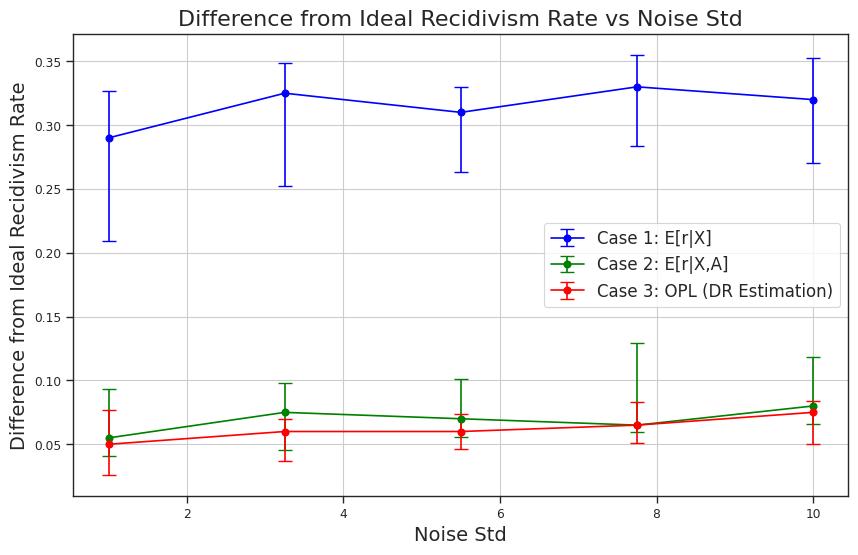

In [408]:
# 理想的な再犯率との差分を計算
diff_median_results = {'Case1': [], 'Case2': [], 'Case3': []}
diff_lower_bounds = {'Case1': [], 'Case2': [], 'Case3': []}
diff_upper_bounds = {'Case1': [], 'Case2': [], 'Case3': []}

for case in ['Case1', 'Case2', 'Case3']:
    for noise_std in noise_levels:
        diff_data = np.array(results[noise_std][case]) - np.array(results[noise_std]['Case0'])
        median = np.median(diff_data)
        lower = np.percentile(diff_data, 2.5)
        upper = np.percentile(diff_data, 97.5)

        diff_median_results[case].append(median)
        diff_lower_bounds[case].append(lower)
        diff_upper_bounds[case].append(upper)

# 差分のプロット
plt.figure(figsize=(10, 6))

for case, label, color in zip(['Case1', 'Case2', 'Case3'],
                              ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)'],
                              ['blue', 'green', 'red']):
    medians = diff_median_results[case]
    lowers = diff_lower_bounds[case]
    uppers = diff_upper_bounds[case]
    plt.errorbar(noise_levels, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt='-o', label=label, color=color, capsize=5)

plt.xlabel('Noise Std', fontsize=14)
plt.ylabel('Difference from Ideal Recidivism Rate', fontsize=14)
plt.title('Difference from Ideal Recidivism Rate vs Noise Std', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# # 推定再犯率 / 理想的再犯率の計算
# ratio_median_results = {'Case1': [], 'Case2': [], 'Case3': []}
# ratio_lower_bounds = {'Case1': [], 'Case2': [], 'Case3': []}
# ratio_upper_bounds = {'Case1': [], 'Case2': [], 'Case3': []}

# for case in ['Case1', 'Case2', 'Case3']:
#     for noise_std in noise_levels:
#         # 推定再犯率と理想的再犯率の比率を計算
#         ratio_data = np.array(results[noise_std][case]) / np.array(results[noise_std]['Case0'])
#         median = np.median(ratio_data)
#         lower = np.percentile(ratio_data, 2.5)
#         upper = np.percentile(ratio_data, 97.5)

#         ratio_median_results[case].append(median)
#         ratio_lower_bounds[case].append(lower)
#         ratio_upper_bounds[case].append(upper)

# # 比率のプロット
# plt.figure(figsize=(10, 6))

# for case, label, color in zip(['Case1', 'Case2', 'Case3'],
#                               ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)'],
#                               ['blue', 'green', 'red']):
#     medians = ratio_median_results[case]
#     lowers = ratio_lower_bounds[case]
#     uppers = ratio_upper_bounds[case]
#     plt.errorbar(noise_levels, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
#                  fmt='-o', label=label, color=color, capsize=5)

# plt.axhline(1, color='k', linestyle='--', label='Ideal Ratio = 1')  # 理想的な比率
# plt.xlabel('Noise Std', fontsize=14)
# plt.ylabel('Estimated / Ideal Recidivism Rate', fontsize=14)
# plt.title('Estimated / Ideal Recidivism Rate vs Noise Std', fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.show()

In [304]:
_col = [_col for _col in list(test_data.columns) if _col.find("X")!=0 ]
_col_c = [_col for _col in list(test_data.columns) if (_col.find("hat")>=0) or  (_col.find("case")>0)]
test_data[_col].corr()[_col_c ]

,ps_hat,q_hat_A1,q_hat_A0,R_case0,R_hat_case1,A_case1,R_case1,A_case2,R_case2,R_case3
A,0.077543,0.140115,-0.084833,-0.042685,-0.079188,-0.001148,-0.065027,-0.162425,0.074088,0.047607
R,0.049991,-0.020366,-0.142173,0.497121,-0.122082,0.017777,0.655300,0.070183,0.450520,0.465473
true_prob_A,0.760057,0.054509,-0.282550,0.095150,-0.445117,-0.160967,0.127329,-0.320135,0.127247,0.074917
R_A0,0.041572,0.103729,-0.112779,0.472866,-0.062945,0.065686,0.719037,-0.068107,0.352438,0.343672
R_A1,0.089068,-0.058951,-0.186832,0.888007,-0.185921,-0.104562,0.555096,0.039290,0.986289,1.000000
ps_hat,1.000000,-0.129691,-0.089401,0.139801,-0.365529,-0.183888,0.159352,-0.162366,0.115240,0.089068
q_hat_A1,-0.129691,1.000000,0.163861,-0.032682,0.410145,0.457486,-0.121853,-0.052356,-0.049879,-0.058951
q_hat_A0,-0.089401,0.163861,1.000000,-0.150676,0.908969,0.465307,-0.254571,0.257364,-0.227987,-0.186832
A_policy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A_ideal,-0.073915,0.138290,0.007160,-0.341515,0.066297,0.147653,0.240776,-0.102161,-0.364936,-0.384586


# 簡易シミュレーションバージョン


Optimization terminated successfully.
         Current function value: 0.631757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584121
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      r   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                 0.07507
Time:                        05:26:48   Log-Likelihood:                -631.76
converged:                       True   LL-Null:                       -683.03
Covariance Type:            nonrobust   LLR p-value:                 5.396e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

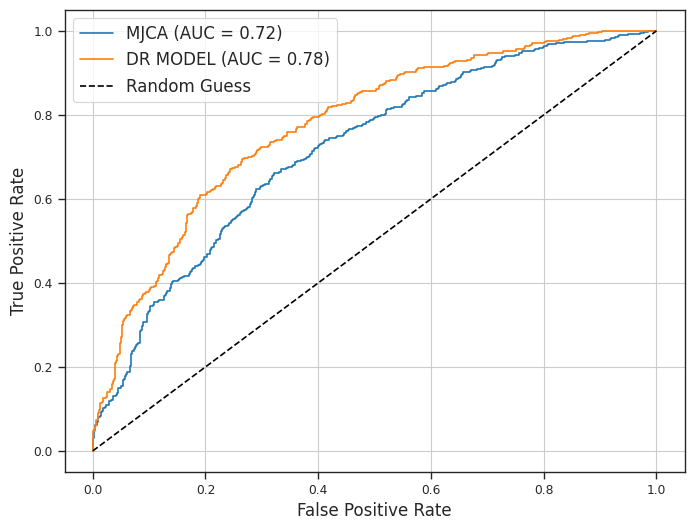

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score

# データ生成プロセス
def generate_simple_data(N=2000, train_ratio=0.5, seed=1):
    np.random.seed(seed)
    # 特徴量 x ("強盗犯罪" フラグ)
    x = np.random.binomial(1, 0.1, N)  # 強盗: 1, その他: 0
    x2 = np.random.normal(0, 1, N) # np.random.binomial(1, 0.5, N)

    # 傾向スコア π_0(a=1 | x="強盗")
    pi_0 = 0.7 * x + 0.25 * (1 - x)

    # 処置 a (少年院送致)
    a = np.random.binomial(1, pi_0, N)

    # ノイズ ε
    epsilon = np.random.normal(0, 1, N)

    # アウトカム r
    z = - 1 * a + 0.5 * x - 0.5 * x2+ epsilon
    r = 1 / (1 + np.exp(-z))  # シグモイド関数

    # 観測されたアウトカム r を 0/1 の離散値に変換
    r_binary = (r > 0.5).astype(int)

    # データフレームの作成
    data = pd.DataFrame({'x': x, 'x2' : x2,'a': a, 'r': r_binary})

    # データを分割
    train_size = int(N * train_ratio)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    return train_data, test_data

# データ生成
train_data, test_data = generate_simple_data(seed=2025)

# MJCAモデル (E[r | x]) を学習 (statsmodels を使用)
X_train = sm.add_constant(train_data[['x', 'x2']])  # 定数項を追加
y_train = train_data['r']
mjca_model = sm.Logit(y_train, X_train).fit()
q_model = sm.Logit(y_train, sm.add_constant(train_data[['x', 'x2', 'a']])).fit()

# モデルの要約を表示
print(mjca_model.summary())
print(q_model.summary())

# テストデータの予測
X_test = sm.add_constant(test_data[['x', 'x2']])
test_data['r_pred'] = mjca_model.predict(X_test)

X_test_q = sm.add_constant(test_data[['x', 'x2', 'a']])
test_data['r_pred_q'] = q_model.predict(X_test_q)

# ROC曲線とAUCスコア
fpr, tpr, thresholds = roc_curve(test_data['r'], test_data['r_pred'])
auc_score = roc_auc_score(test_data['r'], test_data['r_pred'])

fpr_q, tpr_q, thresholds_q = roc_curve(test_data['r'], test_data['r_pred_q'])
auc_score_q = roc_auc_score(test_data['r'], test_data['r_pred_q'])

# ROC曲線をプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MJCA (AUC = {auc_score:.2f})')
plt.plot(fpr_q, tpr_q, label=f'DR MODEL (AUC = {auc_score_q:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('simple_sim_plots.png', dpi=300)
plt.show()

In [110]:
 x=0
 z = 0.8 * x
 1 / (1 + np.exp(-z))

0.5